In [6]:
import sys
import importlib
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch.distributions as dist

sys.path.append("..")
from src import utils, models
importlib.reload(utils)
importlib.reload(models)

<module 'src.models' from '/home/jhaberbe/Projects/Personal/ate/notebook/../src/models.py'>

# Data Setup

In [1]:
import torch
import wandb
import scanpy as sc
import torch.distributions as dist

# AnnData
adata = sc.read_h5ad("/home/jhaberbe/Projects/Personal/ate/data/lipid-droplet.h5ad")
adata = adata[adata.obs["folder"].eq("05-27")]
adata = adata[adata.layers["transcript"].sum(axis=1) > 20]

# Data Setup
data = utils.generate_torch_geometric_data(adata)
data.counts = torch.tensor(adata.layers["transcript"], dtype=torch.float32)
data.near_amyloid = torch.tensor(adata.obs["near_amyloid"].values, dtype=torch.float32)
data.lipid_droplet_area = torch.tensor(adata.obs["lipid_droplet_area"].values, dtype=torch.float32)
data.total_counts = torch.tensor(adata.layers["transcript"].sum(axis=1))
data.size_factors = utils.counts_to_size_factors(data.total_counts)
data.cell_type_encoded = torch.tensor(pd.get_dummies(adata.obs["cell_type"].cat.codes).astype(float).values)

category_mapping = {cat: code for code, cat in enumerate(adata.obs["cell_type"].cat.categories)}
category_mapping

# Model Setup
nb_model = models.JointEmbeddingGATv2NBNet(len(category_mapping), 64, 64, data.x.shape[1])

# Send to proper devices.
device = "cuda"
data.to(device)
nb_model.to(device)

# Training routine.
optimizer = torch.optim.Adam(nb_model.parameters(), lr=1e-4, weight_decay=1e-4)
num_epochs = 2_000

/home/jhaberbe/Projects/Personal/ate/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


NameError: name 'utils' is not defined

In [ ]:
wandb.init(project="ate", name="gatv2_nb_training")

for epoch in range(num_epochs):
    nb_model.train()
    optimizer.zero_grad()

    logits, dispersion = nb_model(
        data.cell_type_encoded.int(), 
        data.lipid_droplet_area, 
        data.edge_index
    )

    nb_dist = dist.NegativeBinomial(
        logits=logits + data.size_factors.repeat(logits.shape[1], 1).T,
        total_count=dispersion
    )
    log_likelihood = nb_dist.log_prob(data.counts).sum(axis=1).mean()
    loss = -log_likelihood
    loss.backward()
    optimizer.step()
    wandb.log({"epoch": epoch + 1, "loss": loss.item(), "log_likelihood": log_likelihood.item()})
    if epoch % 100 == 0:
        print({"epoch": epoch + 1, "loss": loss.item(), "log_likelihood": log_likelihood.item()})

In [110]:
torch.save(nb_model.state_dict(), "../models/gatv2_nb_model.pth")
nb_model.load_state_dict(torch.load("../models/gatv2_nb_model.pth"))

<All keys matched successfully>

# Example of Treatment Effect
- For example, what is the expected effect of lipid droplets, conditioned on the neighborhood.

In [2]:
def perform_lipid_perturbation(
        adata,
        data,
        cell_type,
        nb_model
    ):
    indices = np.arange(adata.shape[0])[
        adata.obs["cell_type"].eq(cell_type) 
        & 
        adata.obs["lipid_droplet_area"].gt(0)
        & 
        adata.obs["near_amyloid"].eq(0)
    ]

    nb_model.to(device)

    results = {}

    for idx in tqdm(indices):
        x_clone = data.x.clone()
        lipid_droplet_area_clone = data.lipid_droplet_area.clone()
        lipid_droplet_area_clone[idx] = 0.0
        nb_model.eval()
        with torch.no_grad():
            logits, dispersion = nb_model(
                data.cell_type_encoded.int(), 
                data.lipid_droplet_area, 
                data.edge_index
            )

            results[idx] = logits[idx].cpu().detach()

    treatment = pd.DataFrame(
        results, 
        index=adata.var_names
    ).T

    logits, _ = nb_model(
        data.cell_type_encoded.int(), 
        data.lipid_droplet_area > 0, 
        data.edge_index
    )

    null = pd.DataFrame(
        logits[treatment.index].cpu().detach().numpy(), 
        index=treatment.index, 
        columns=adata.var_names
    )

    return (treatment - null) \
        .assign(mean_area = np.log1p(adata.obs["lipid_droplet_area"]).iloc[treatment.index].tolist())

# Visualization

Could probably be done with gaussian processes.
- Maybe the output linear layer could be done with GPs too!

In [ ]:
mean_area = np.log1p(adata[
    adata.obs["cell_type"].eq("L2/3 IT") 
    & 
    adata.obs["lipid_droplet_area"].gt(0)
    & 
    adata.obs["near_amyloid"].eq(0)
].obs["lipid_droplet_area"])

expressed = (adata[
    adata.obs["cell_type"].eq("L2/3 IT") 
    & 
    adata.obs["lipid_droplet_area"].gt(0)
    & 
    adata.obs["near_amyloid"].eq(0)
].layers["transcript"] > 1).mean(axis=0) > .3

(treatment - null).div(mean_area.tolist(), axis=0).mean(axis=0).plot.kde()
(treatment - null).div(mean_area.tolist(), axis=0).mean(axis=0).sort_values()[expressed]

<Axes: xlabel='mean_area', ylabel='TPH2'>

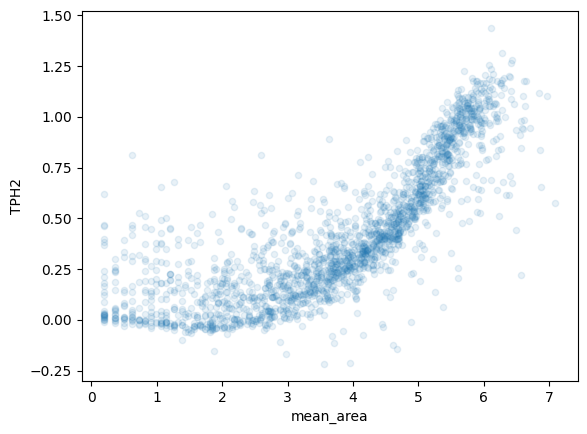

In [530]:
(treatment - null).assign(mean_area = mean_area.tolist()).plot.scatter(
    x="mean_area",
    y="TPH2",
    alpha = 0.1
)

# Changes cell type in the neighborhood.

In [3]:
import torch
from tqdm import tqdm
import random
import pandas as pd

import torch
import random
import numpy as np
import pandas as pd
from torch_geometric.utils import k_hop_subgraph
from tqdm import tqdm

def perform_neighbor_perturbation(
        adata,
        data,
        cell_type_testing,
        cell_type_perturb,
        category_mapping,
        nb_model
    ):

    indices = np.arange(adata.shape[0])[
        adata.obs["cell_type"].eq(cell_type_testing) 
        & 
        adata.obs["lipid_droplet_area"].gt(0)
        & 
        adata.obs["near_amyloid"].eq(0)
    ]

    nb_model.to(device)
    results = {}
    target_cell_type = category_mapping[cell_type_perturb]

    # full edge index
    edge_index = data.edge_index

    for idx in indices:
        # extract 2-hop subgraph
        subset, sub_edge_index, mapping, _ = k_hop_subgraph(
            torch.tensor([idx]), 
            num_hops=2, 
            edge_index=edge_index, 
            relabel_nodes=True
        )

        # remap everything to local subgraph
        cell_type_clone = data.cell_type_encoded[subset].clone()
        lipid_droplet_area = data.lipid_droplet_area[subset]

        center_idx = mapping.item()  # local index of target cell
        num_nodes = len(subset)

        # Find neighbors within the subgraph (1-hop)
        neighbors = sub_edge_index[1][sub_edge_index[0] == center_idx].tolist()
        if not neighbors:
            continue  # skip if isolated

        chosen_neighbor = random.choice(neighbors)
        i = 0
        while (cell_type_clone[chosen_neighbor].argmax() == target_cell_type) and i < 10:
            chosen_neighbor = random.choice(neighbors)
            i += 1

        # Replace cell type
        cell_type_clone[chosen_neighbor][cell_type_clone[chosen_neighbor].argmax()] = 0
        cell_type_clone[chosen_neighbor][target_cell_type] = 1

        # Run model on subgraph
        nb_model.eval()
        with torch.no_grad():
            logits, _ = nb_model(
                cell_type_clone.int().to(device),
                lipid_droplet_area.to(device),
                sub_edge_index.to(device)
            )

        results[idx] = logits[center_idx].cpu().detach()

    # Compile treatment effect
    treatment = pd.DataFrame(results, index=adata.var_names).T

    # Null model using full graph
    logits, _ = nb_model(
        data.cell_type_encoded.int().to(device), 
        data.lipid_droplet_area.to(device), 
        data.edge_index.to(device)
    )

    null = pd.DataFrame(
        logits[treatment.index].cpu().detach().numpy(), 
        index=treatment.index, 
        columns=adata.var_names
    )

    return treatment - null

In [ ]:

pairwise_testing = {
    cell_type: {
        cell_type_perturb: perform_neighbor_perturbation(adata, data, cell_type, cell_type_perturb, category_mapping, nb_model)
        for cell_type_perturb in adata.obs.query('cell_type != @cell_type')["cell_type"].unique()
    }
    for cell_type in tqdm(adata.obs["cell_type"].unique())
}

In [471]:
outcomes = []

for cell_type in adata.obs["cell_type"].unique():
    mean_expression = pd.Series(
        adata[adata.obs["cell_type"].eq(cell_type)].X.mean(axis=0),
        index=adata.var_names
    )

    for cell_type_perturb, average_treatment_effect in pairwise_testing[cell_type].items():
        if average_treatment_effect.shape[0] > 200:
            aggregate = {
                "cell_type": cell_type,
                "cell_type_perturb": cell_type_perturb,
                "effect":  (average_treatment_effect.mean(axis=0))[mean_expression > 0.5].abs().sum(), 
            }
            per_gene = {
                gene: (average_treatment_effect[gene].mean() if (mean_expression.loc[gene] > 0.5) else None)
                for gene in average_treatment_effect.columns
            }
            aggregate.update(per_gene)
            outcomes.append(aggregate)


<Axes: xlabel='cell_type_perturb', ylabel='cell_type'>

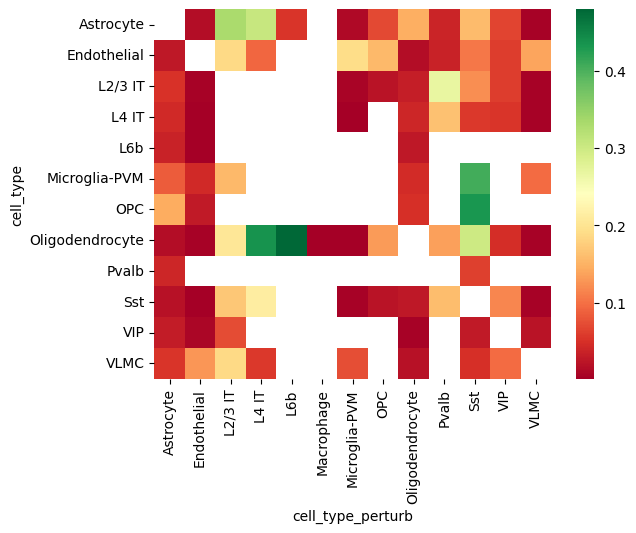

In [472]:
import seaborn as sns
heatmap = pd.DataFrame(outcomes).pivot_table(index="cell_type", columns="cell_type_perturb", values="effect")
sns.heatmap(heatmap, cmap="RdYlGn")

<Axes: xlabel='cell_type_perturb', ylabel='cell_type'>

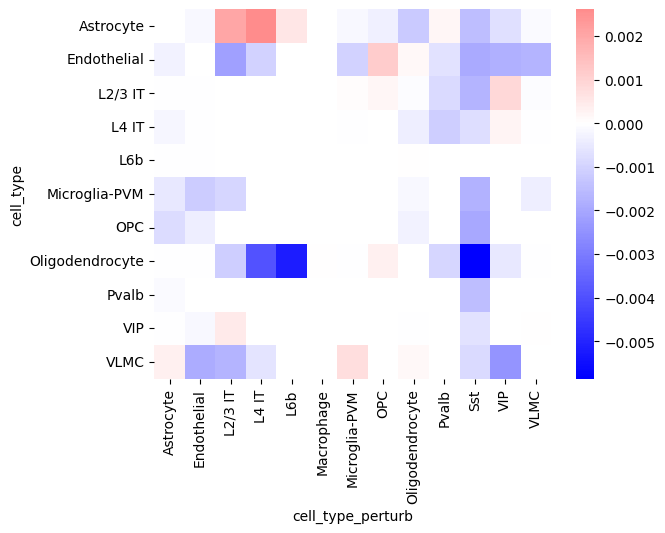

In [486]:
import seaborn as sns
heatmap = pd.DataFrame(outcomes).pivot_table(
    index="cell_type", 
    columns="cell_type_perturb", 
    values="LAMP1"
)
sns.heatmap(heatmap, cmap="bwr", center=0)

# What's the effect of inducing lipid droplet changes in a cell.

- Suppose we want to see what the effect is on a cell if we change the amount of lipid in its' neighboring cells, where will the effect be strongest.

In [4]:
import torch
import random
import numpy as np
import pandas as pd
from torch_geometric.utils import k_hop_subgraph
from tqdm import tqdm

def perform_neighbor_lipid_perturbation(
    adata, 
    data, 
    cell_type_testing, 
    cell_type_perturb, 
    category_mapping,
    new_lipid_value=0.0, 
    min_lipid_size=4.0
):
    # Todo: adjust so that we can add new bounds, question addition vs removal of lipid droplet.
    indices = np.arange(adata.shape[0])[
        adata.obs["cell_type"].eq(cell_type_testing) 
        & 
        adata.obs["lipid_droplet_area"].gt(0.0)
        & 
        adata.obs["near_amyloid"].eq(0)
    ]


    nb_model.to(device)
    results = {}
    target_cell_type = category_mapping[cell_type_perturb]
    edge_index = data.edge_index

    for idx in indices:
        # extract 2-hop subgraph
        subset, sub_edge_index, mapping, _ = k_hop_subgraph(
            torch.tensor([idx]), 
            num_hops=2, 
            edge_index=edge_index, 
            relabel_nodes=True
        )

        # Get subgraph feature tensors
        cell_type_clone = data.cell_type_encoded[subset].clone()
        lipid_droplet_area = data.lipid_droplet_area[subset].clone()

        center_idx = mapping.item()  # local index of target cell

        # Find matching cell type in subgraph (excluding the target)
        candidate_indices = [
            i for i in range(len(subset))
            if ((i != center_idx) & (cell_type_clone[i].argmax().item() == target_cell_type) & (lipid_droplet_area[i] > min_lipid_size))
        ]

        if not candidate_indices:
            continue  # skip if no perturbable cell found

        chosen_perturb_idx = random.choice(candidate_indices)

        # Replace lipid droplet value of that cell
        lipid_droplet_area[chosen_perturb_idx] = new_lipid_value

        # Run model on subgraph
        nb_model.eval()
        with torch.no_grad():
            logits, _ = nb_model(
                cell_type_clone.int().to(device),
                lipid_droplet_area.to(device),
                sub_edge_index.to(device)
            )

        results[idx] = logits[center_idx].cpu().detach()

    # Compile treatment effect
    treatment = pd.DataFrame(results, index=adata.var_names).T

    # Null model using full graph
    logits, _ = nb_model(
        data.cell_type_encoded.int().to(device), 
        data.lipid_droplet_area.to(device), 
        data.edge_index.to(device)
    )

    null = pd.DataFrame(
        logits[treatment.index].cpu().detach().numpy(), 
        index=treatment.index, 
        columns=adata.var_names
    )

    return treatment - null


In [ ]:

pairwise_testing = {
    cell_type: {
        cell_type_perturb: perform_neighbor_lipid_perturbation(
            adata, 
            data, 
            cell_type, 
            cell_type_perturb, 
            category_mapping,
            new_lipid_value=0.0
        )
        for cell_type_perturb in adata.obs.query('cell_type != @cell_type')["cell_type"].unique()
    }
    for cell_type in tqdm(adata.obs["cell_type"].unique())
}

In [490]:
outcomes = []

for cell_type in adata.obs["cell_type"].unique():
    mean_expression = pd.Series(
        adata[adata.obs["cell_type"].eq(cell_type)].X.mean(axis=0),
        index=adata.var_names
    )

    for cell_type_perturb, average_treatment_effect in pairwise_testing[cell_type].items():
        if average_treatment_effect.shape[0] > 200:
            aggregate = {
                "cell_type": cell_type,
                "cell_type_perturb": cell_type_perturb,
                "effect":  (mean_expression * average_treatment_effect.mean(axis=0)).abs().sum(), 
            }
            per_gene = {
                gene: (average_treatment_effect[gene].mean() if mean_expression.loc[gene] > .5 else 0)
                for gene in average_treatment_effect.columns
            }
            aggregate.update(per_gene)
            outcomes.append(aggregate)

<Axes: xlabel='cell_type_perturb', ylabel='cell_type'>

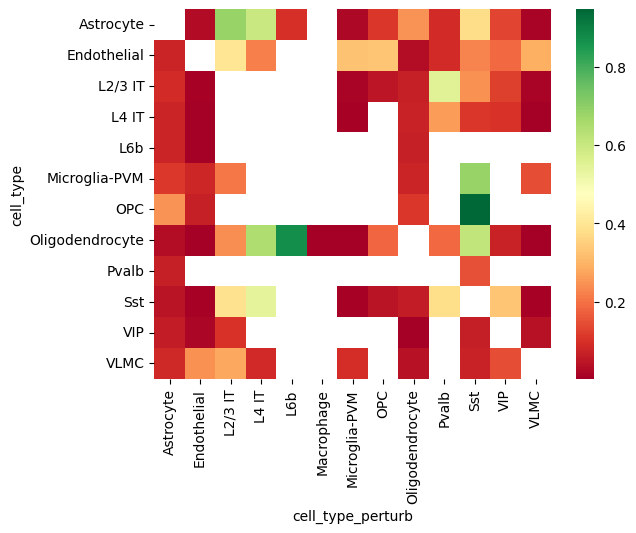

In [491]:
import seaborn as sns
heatmap = pd.DataFrame(outcomes).pivot_table(index="cell_type", columns="cell_type_perturb", values="effect")
sns.heatmap(heatmap, cmap="RdYlGn")

# Generalized Pipeline

In [7]:
# Pipeline to test all specimens:
import os
import pickle
import torch
import wandb
import scanpy as sc
import torch.distributions as dist

# AnnData
adata = sc.read_h5ad("/home/jhaberbe/Projects/Personal/ate/data/lipid-droplet.h5ad")
for folder in adata.obs["folder"].unique():
    adata = sc.read_h5ad("/home/jhaberbe/Projects/Personal/ate/data/lipid-droplet.h5ad")
    adata = adata[adata.obs["folder"].eq(folder)]
    adata = adata[adata.layers["transcript"].sum(axis=1) > 20]

    # Data Setup
    data = utils.generate_torch_geometric_data(adata)
    data.counts = torch.tensor(adata.layers["transcript"], dtype=torch.float32)
    data.near_amyloid = torch.tensor(adata.obs["near_amyloid"].values, dtype=torch.float32)
    data.lipid_droplet_area = torch.tensor(adata.obs["lipid_droplet_area"].values, dtype=torch.float32)
    data.total_counts = torch.tensor(adata.layers["transcript"].sum(axis=1))
    data.size_factors = utils.counts_to_size_factors(data.total_counts)
    data.cell_type_encoded = torch.tensor(pd.get_dummies(adata.obs["cell_type"].cat.codes).astype(float).values)

    category_mapping = {cat: code for code, cat in enumerate(adata.obs["cell_type"].cat.categories)}
    category_mapping

    # Model Setup
    nb_model = models.JointEmbeddingGATv2NBNet(len(category_mapping), 64, 64, data.x.shape[1])

    # Send to proper devices.
    device = "cuda"
    data.to(device)
    nb_model.to(device)

    # Training routine.
    optimizer = torch.optim.Adam(nb_model.parameters(), lr=1e-4, weight_decay=1e-4)
    num_epochs = 5_000

    wandb.init(project="ate", name=f"{folder}")

    for epoch in range(num_epochs):
        nb_model.train()
        optimizer.zero_grad()

        logits, dispersion = nb_model(
            data.cell_type_encoded.int(), 
            data.lipid_droplet_area, 
            data.edge_index
        )

        nb_dist = dist.NegativeBinomial(
            logits=logits + data.size_factors.repeat(logits.shape[1], 1).T,
            total_count=dispersion
        )
        log_likelihood = nb_dist.log_prob(data.counts).sum(axis=1).mean()
        loss = -log_likelihood
        loss.backward()
        optimizer.step()
        wandb.log({"epoch": epoch + 1, "loss": loss.item(), "log_likelihood": log_likelihood.item()})
        if epoch % 100 == 0:
            print({"epoch": epoch + 1, "loss": loss.item(), "log_likelihood": log_likelihood.item()})

    torch.save(nb_model.state_dict(), f"../models/{folder}.pth")
    nb_model.load_state_dict(torch.load(f"../models/{folder}.pth"))

    lipid_perturbation = {
        cell_type: perform_lipid_perturbation(adata, data, cell_type, nb_model)
        for cell_type in adata.obs["cell_type"].unique()
    }

    neighbor_perturbation = {
        cell_type: {
            cell_type_perturb: perform_neighbor_perturbation(adata, data, cell_type, cell_type_perturb, category_mapping, nb_model)
            for cell_type_perturb in adata.obs.query('cell_type != @cell_type')["cell_type"].unique()
        }
        for cell_type in tqdm(adata.obs["cell_type"].unique())
    }

    neighbor_lipid_perturbation = {
        cell_type: {
            cell_type_perturb: perform_neighbor_lipid_perturbation(
                adata, 
                data, 
                cell_type, 
                cell_type_perturb, 
                category_mapping,
                new_lipid_value=0.0
            )
            for cell_type_perturb in adata.obs.query('cell_type != @cell_type')["cell_type"].unique()
        }
        for cell_type in tqdm(adata.obs["cell_type"].unique())
    }

    # Ensure the output directory exists
    os.makedirs(f"/home/jhaberbe/Projects/Personal/ate/output/{folder}", exist_ok=True)

    with open(f"/home/jhaberbe/Projects/Personal/ate/output/{folder}/lipid_perturbation.pickle", "wb") as f:
        pickle.dump(lipid_perturbation, f)

    with open(f"/home/jhaberbe/Projects/Personal/ate/output/{folder}/neighbor_perturbation.pickle", "wb") as f:
        pickle.dump(neighbor_perturbation, f)

    with open(f"/home/jhaberbe/Projects/Personal/ate/output/{folder}/neighbor_lipid_perturbation.pickle", "wb") as f:
        pickle.dump(neighbor_lipid_perturbation, f)


/home/jhaberbe/Projects/Personal/ate/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/jhaberbe/Projects/Personal/ate/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
wandb: Currently logged in as: jhaberbe (kibr) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


{'epoch': 1, 'loss': 415.6707763671875, 'log_likelihood': -415.6707763671875}
{'epoch': 101, 'loss': 357.18109130859375, 'log_likelihood': -357.18109130859375}
{'epoch': 201, 'loss': 319.60174560546875, 'log_likelihood': -319.60174560546875}
{'epoch': 301, 'loss': 314.0191650390625, 'log_likelihood': -314.0191650390625}
{'epoch': 401, 'loss': 311.1198425292969, 'log_likelihood': -311.1198425292969}
{'epoch': 501, 'loss': 308.753662109375, 'log_likelihood': -308.753662109375}
{'epoch': 601, 'loss': 306.53717041015625, 'log_likelihood': -306.53717041015625}
{'epoch': 701, 'loss': 304.3197937011719, 'log_likelihood': -304.3197937011719}
{'epoch': 801, 'loss': 302.0035095214844, 'log_likelihood': -302.0035095214844}
{'epoch': 901, 'loss': 299.6819763183594, 'log_likelihood': -299.6819763183594}
{'epoch': 1001, 'loss': 297.5267333984375, 'log_likelihood': -297.5267333984375}
{'epoch': 1101, 'loss': 295.28387451171875, 'log_likelihood': -295.28387451171875}
{'epoch': 1201, 'loss': 293.207458

100%|██████████| 13/13 [03:20<00:00, 15.42s/it]
/home/jhaberbe/Projects/Personal/ate/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇████
log_likelihood,▁▁▆▆▆▆▆▇▇▇▇▇▇▇▇▇████████████████████████
loss,██▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,5000
log_likelihood,-261.65436
loss,261.65436


{'epoch': 1, 'loss': 1144.2889404296875, 'log_likelihood': -1144.2889404296875}
{'epoch': 101, 'loss': 461.48114013671875, 'log_likelihood': -461.48114013671875}
{'epoch': 201, 'loss': 338.0642395019531, 'log_likelihood': -338.0642395019531}
{'epoch': 301, 'loss': 302.7829895019531, 'log_likelihood': -302.7829895019531}
{'epoch': 401, 'loss': 290.46368408203125, 'log_likelihood': -290.46368408203125}
{'epoch': 501, 'loss': 284.2815246582031, 'log_likelihood': -284.2815246582031}
{'epoch': 601, 'loss': 280.6233825683594, 'log_likelihood': -280.6233825683594}
{'epoch': 701, 'loss': 278.1181640625, 'log_likelihood': -278.1181640625}
{'epoch': 801, 'loss': 276.36102294921875, 'log_likelihood': -276.36102294921875}
{'epoch': 901, 'loss': 275.0660095214844, 'log_likelihood': -275.0660095214844}
{'epoch': 1001, 'loss': 274.0628662109375, 'log_likelihood': -274.0628662109375}
{'epoch': 1101, 'loss': 273.2434997558594, 'log_likelihood': -273.2434997558594}
{'epoch': 1201, 'loss': 272.5450134277

100%|██████████| 13/13 [03:05<00:00, 14.29s/it]
/home/jhaberbe/Projects/Personal/ate/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
log_likelihood,▁▂▇▇▇███████████████████████████████████
loss,██▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch,5000
log_likelihood,-243.6299
loss,243.6299


{'epoch': 1, 'loss': 323.7893371582031, 'log_likelihood': -323.7893371582031}
{'epoch': 101, 'loss': 278.52471923828125, 'log_likelihood': -278.52471923828125}
{'epoch': 201, 'loss': 237.92861938476562, 'log_likelihood': -237.92861938476562}
{'epoch': 301, 'loss': 212.25022888183594, 'log_likelihood': -212.25022888183594}
{'epoch': 401, 'loss': 208.994140625, 'log_likelihood': -208.994140625}
{'epoch': 501, 'loss': 207.43141174316406, 'log_likelihood': -207.43141174316406}
{'epoch': 601, 'loss': 206.18527221679688, 'log_likelihood': -206.18527221679688}
{'epoch': 701, 'loss': 205.06591796875, 'log_likelihood': -205.06591796875}
{'epoch': 801, 'loss': 204.01980590820312, 'log_likelihood': -204.01980590820312}
{'epoch': 901, 'loss': 203.01747131347656, 'log_likelihood': -203.01747131347656}
{'epoch': 1001, 'loss': 201.99209594726562, 'log_likelihood': -201.99209594726562}
{'epoch': 1101, 'loss': 200.9397735595703, 'log_likelihood': -200.9397735595703}
{'epoch': 1201, 'loss': 199.75761413

100%|██████████| 13/13 [05:10<00:00, 23.85s/it]
/home/jhaberbe/Projects/Personal/ate/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇█
log_likelihood,▁▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████
loss,███▆▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,5000
log_likelihood,-180.36586
loss,180.36586


{'epoch': 1, 'loss': 270.7922668457031, 'log_likelihood': -270.7922668457031}
{'epoch': 101, 'loss': 252.2812042236328, 'log_likelihood': -252.2812042236328}
{'epoch': 201, 'loss': 222.22959899902344, 'log_likelihood': -222.22959899902344}
{'epoch': 301, 'loss': 198.23744201660156, 'log_likelihood': -198.23744201660156}
{'epoch': 401, 'loss': 187.59666442871094, 'log_likelihood': -187.59666442871094}
{'epoch': 501, 'loss': 184.43145751953125, 'log_likelihood': -184.43145751953125}
{'epoch': 601, 'loss': 182.3463897705078, 'log_likelihood': -182.3463897705078}
{'epoch': 701, 'loss': 180.57569885253906, 'log_likelihood': -180.57569885253906}
{'epoch': 801, 'loss': 179.19200134277344, 'log_likelihood': -179.19200134277344}
{'epoch': 901, 'loss': 178.16180419921875, 'log_likelihood': -178.16180419921875}
{'epoch': 1001, 'loss': 177.35568237304688, 'log_likelihood': -177.35568237304688}
{'epoch': 1101, 'loss': 176.69187927246094, 'log_likelihood': -176.69187927246094}
{'epoch': 1201, 'loss'

100%|██████████| 13/13 [05:30<00:00, 25.41s/it]
/home/jhaberbe/Projects/Personal/ate/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


epoch,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▇▇▇▇▇█████
log_likelihood,▁▁▄▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
loss,█▇▅▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,5000
log_likelihood,-160.20105
loss,160.20105


{'epoch': 1, 'loss': 1044.692138671875, 'log_likelihood': -1044.692138671875}
{'epoch': 101, 'loss': 308.29656982421875, 'log_likelihood': -308.29656982421875}
{'epoch': 201, 'loss': 295.7754211425781, 'log_likelihood': -295.7754211425781}
{'epoch': 301, 'loss': 276.69140625, 'log_likelihood': -276.69140625}
{'epoch': 401, 'loss': 258.06500244140625, 'log_likelihood': -258.06500244140625}
{'epoch': 501, 'loss': 244.2899169921875, 'log_likelihood': -244.2899169921875}
{'epoch': 601, 'loss': 235.20428466796875, 'log_likelihood': -235.20428466796875}
{'epoch': 701, 'loss': 229.65476989746094, 'log_likelihood': -229.65476989746094}
{'epoch': 801, 'loss': 226.16943359375, 'log_likelihood': -226.16943359375}
{'epoch': 901, 'loss': 223.79226684570312, 'log_likelihood': -223.79226684570312}
{'epoch': 1001, 'loss': 222.01626586914062, 'log_likelihood': -222.01626586914062}
{'epoch': 1101, 'loss': 220.58766174316406, 'log_likelihood': -220.58766174316406}
{'epoch': 1201, 'loss': 219.365982055664

100%|██████████| 13/13 [06:23<00:00, 29.51s/it]
/home/jhaberbe/Projects/Personal/ate/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
log_likelihood,▁▁▂▂▃▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,5000
log_likelihood,-195.65393
loss,195.65393


{'epoch': 1, 'loss': 590.307861328125, 'log_likelihood': -590.307861328125}
{'epoch': 101, 'loss': 417.32159423828125, 'log_likelihood': -417.32159423828125}
{'epoch': 201, 'loss': 391.10400390625, 'log_likelihood': -391.10400390625}
{'epoch': 301, 'loss': 343.3162841796875, 'log_likelihood': -343.3162841796875}
{'epoch': 401, 'loss': 305.98675537109375, 'log_likelihood': -305.98675537109375}
{'epoch': 501, 'loss': 297.4411926269531, 'log_likelihood': -297.4411926269531}
{'epoch': 601, 'loss': 293.9269714355469, 'log_likelihood': -293.9269714355469}
{'epoch': 701, 'loss': 291.343017578125, 'log_likelihood': -291.343017578125}
{'epoch': 801, 'loss': 289.25, 'log_likelihood': -289.25}
{'epoch': 901, 'loss': 287.5230407714844, 'log_likelihood': -287.5230407714844}
{'epoch': 1001, 'loss': 286.08685302734375, 'log_likelihood': -286.08685302734375}
{'epoch': 1101, 'loss': 284.873046875, 'log_likelihood': -284.873046875}
{'epoch': 1201, 'loss': 283.8227233886719, 'log_likelihood': -283.822723

100%|██████████| 13/13 [02:05<00:00,  9.64s/it]
/home/jhaberbe/Projects/Personal/ate/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


epoch,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
log_likelihood,▁▂▄▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
loss,█▇▇▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,5000
log_likelihood,-256.89389
loss,256.89389


{'epoch': 1, 'loss': 1925.7215576171875, 'log_likelihood': -1925.7215576171875}
{'epoch': 101, 'loss': 432.247314453125, 'log_likelihood': -432.247314453125}
{'epoch': 201, 'loss': 365.1920471191406, 'log_likelihood': -365.1920471191406}
{'epoch': 301, 'loss': 324.08392333984375, 'log_likelihood': -324.08392333984375}
{'epoch': 401, 'loss': 306.5295715332031, 'log_likelihood': -306.5295715332031}
{'epoch': 501, 'loss': 296.2380676269531, 'log_likelihood': -296.2380676269531}
{'epoch': 601, 'loss': 290.0135498046875, 'log_likelihood': -290.0135498046875}
{'epoch': 701, 'loss': 286.255615234375, 'log_likelihood': -286.255615234375}
{'epoch': 801, 'loss': 283.898193359375, 'log_likelihood': -283.898193359375}
{'epoch': 901, 'loss': 282.3191833496094, 'log_likelihood': -282.3191833496094}
{'epoch': 1001, 'loss': 281.1314392089844, 'log_likelihood': -281.1314392089844}
{'epoch': 1101, 'loss': 280.1792297363281, 'log_likelihood': -280.1792297363281}
{'epoch': 1201, 'loss': 279.3531494140625,

100%|██████████| 13/13 [05:36<00:00, 25.88s/it]
/home/jhaberbe/Projects/Personal/ate/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇███
log_likelihood,▁▃▃▃▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,5000
log_likelihood,-250.05502
loss,250.05502


{'epoch': 1, 'loss': 386.67022705078125, 'log_likelihood': -386.67022705078125}
{'epoch': 101, 'loss': 346.69189453125, 'log_likelihood': -346.69189453125}
{'epoch': 201, 'loss': 302.5466003417969, 'log_likelihood': -302.5466003417969}
{'epoch': 301, 'loss': 297.28167724609375, 'log_likelihood': -297.28167724609375}
{'epoch': 401, 'loss': 294.5917053222656, 'log_likelihood': -294.5917053222656}
{'epoch': 501, 'loss': 292.04498291015625, 'log_likelihood': -292.04498291015625}
{'epoch': 601, 'loss': 289.5198669433594, 'log_likelihood': -289.5198669433594}
{'epoch': 701, 'loss': 287.2762451171875, 'log_likelihood': -287.2762451171875}
{'epoch': 801, 'loss': 285.3461608886719, 'log_likelihood': -285.3461608886719}
{'epoch': 901, 'loss': 283.49981689453125, 'log_likelihood': -283.49981689453125}
{'epoch': 1001, 'loss': 281.7315368652344, 'log_likelihood': -281.7315368652344}
{'epoch': 1101, 'loss': 279.9131774902344, 'log_likelihood': -279.9131774902344}
{'epoch': 1201, 'loss': 278.13076782

100%|██████████| 13/13 [03:18<00:00, 15.27s/it]
/home/jhaberbe/Projects/Personal/ate/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
log_likelihood,▁▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████████████████
loss,█▆▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,5000
log_likelihood,-250.39651
loss,250.39651


{'epoch': 1, 'loss': 227.6172332763672, 'log_likelihood': -227.6172332763672}
{'epoch': 101, 'loss': 203.41595458984375, 'log_likelihood': -203.41595458984375}
{'epoch': 201, 'loss': 144.36688232421875, 'log_likelihood': -144.36688232421875}
{'epoch': 301, 'loss': 136.75460815429688, 'log_likelihood': -136.75460815429688}
{'epoch': 401, 'loss': 133.86912536621094, 'log_likelihood': -133.86912536621094}
{'epoch': 501, 'loss': 131.7445068359375, 'log_likelihood': -131.7445068359375}
{'epoch': 601, 'loss': 130.01759338378906, 'log_likelihood': -130.01759338378906}
{'epoch': 701, 'loss': 128.5843048095703, 'log_likelihood': -128.5843048095703}
{'epoch': 801, 'loss': 127.38565063476562, 'log_likelihood': -127.38565063476562}
{'epoch': 901, 'loss': 126.38223266601562, 'log_likelihood': -126.38223266601562}
{'epoch': 1001, 'loss': 125.52711486816406, 'log_likelihood': -125.52711486816406}
{'epoch': 1101, 'loss': 124.78604888916016, 'log_likelihood': -124.78604888916016}
{'epoch': 1201, 'loss'

100%|██████████| 13/13 [04:24<00:00, 20.31s/it]
/home/jhaberbe/Projects/Personal/ate/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▁▁▁▁▂▂▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
log_likelihood,▁▂▄▅▆▇▇▇▇▇▇▇▇▇▇█████████████████████████
loss,██▇▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,5000
log_likelihood,-112.74895
loss,112.74895


{'epoch': 1, 'loss': 376.169677734375, 'log_likelihood': -376.169677734375}
{'epoch': 101, 'loss': 354.6604919433594, 'log_likelihood': -354.6604919433594}
{'epoch': 201, 'loss': 299.1971740722656, 'log_likelihood': -299.1971740722656}
{'epoch': 301, 'loss': 291.1859130859375, 'log_likelihood': -291.1859130859375}
{'epoch': 401, 'loss': 288.4638366699219, 'log_likelihood': -288.4638366699219}
{'epoch': 501, 'loss': 286.3030090332031, 'log_likelihood': -286.3030090332031}
{'epoch': 601, 'loss': 284.13189697265625, 'log_likelihood': -284.13189697265625}
{'epoch': 701, 'loss': 281.7611999511719, 'log_likelihood': -281.7611999511719}
{'epoch': 801, 'loss': 279.11639404296875, 'log_likelihood': -279.11639404296875}
{'epoch': 901, 'loss': 276.2288513183594, 'log_likelihood': -276.2288513183594}
{'epoch': 1001, 'loss': 273.8312072753906, 'log_likelihood': -273.8312072753906}
{'epoch': 1101, 'loss': 271.88690185546875, 'log_likelihood': -271.88690185546875}
{'epoch': 1201, 'loss': 270.19073486

100%|██████████| 13/13 [03:42<00:00, 17.10s/it]
/home/jhaberbe/Projects/Personal/ate/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇█████
log_likelihood,▁▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████
loss,█▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,5000
log_likelihood,-244.97844
loss,244.97844


{'epoch': 1, 'loss': 1348.046630859375, 'log_likelihood': -1348.046630859375}
{'epoch': 101, 'loss': 491.4797058105469, 'log_likelihood': -491.4797058105469}
{'epoch': 201, 'loss': 322.2375183105469, 'log_likelihood': -322.2375183105469}
{'epoch': 301, 'loss': 295.2587890625, 'log_likelihood': -295.2587890625}
{'epoch': 401, 'loss': 271.0736999511719, 'log_likelihood': -271.0736999511719}
{'epoch': 501, 'loss': 257.9231872558594, 'log_likelihood': -257.9231872558594}
{'epoch': 601, 'loss': 251.0644073486328, 'log_likelihood': -251.0644073486328}
{'epoch': 701, 'loss': 246.9945831298828, 'log_likelihood': -246.9945831298828}
{'epoch': 801, 'loss': 244.29232788085938, 'log_likelihood': -244.29232788085938}
{'epoch': 901, 'loss': 242.4452362060547, 'log_likelihood': -242.4452362060547}
{'epoch': 1001, 'loss': 240.98843383789062, 'log_likelihood': -240.98843383789062}
{'epoch': 1101, 'loss': 239.75625610351562, 'log_likelihood': -239.75625610351562}
{'epoch': 1201, 'loss': 238.669067382812

100%|██████████| 13/13 [05:12<00:00, 24.05s/it]
/home/jhaberbe/Projects/Personal/ate/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
log_likelihood,▁▃▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
loss,█▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,5000
log_likelihood,-216.65796
loss,216.65796


{'epoch': 1, 'loss': 577.6964111328125, 'log_likelihood': -577.6964111328125}
{'epoch': 101, 'loss': 382.78466796875, 'log_likelihood': -382.78466796875}
{'epoch': 201, 'loss': 364.25494384765625, 'log_likelihood': -364.25494384765625}
{'epoch': 301, 'loss': 336.6022644042969, 'log_likelihood': -336.6022644042969}
{'epoch': 401, 'loss': 311.44525146484375, 'log_likelihood': -311.44525146484375}
{'epoch': 501, 'loss': 297.5476379394531, 'log_likelihood': -297.5476379394531}
{'epoch': 601, 'loss': 291.5263977050781, 'log_likelihood': -291.5263977050781}
{'epoch': 701, 'loss': 288.8117980957031, 'log_likelihood': -288.8117980957031}
{'epoch': 801, 'loss': 287.3106689453125, 'log_likelihood': -287.3106689453125}
{'epoch': 901, 'loss': 286.2644348144531, 'log_likelihood': -286.2644348144531}
{'epoch': 1001, 'loss': 285.3714599609375, 'log_likelihood': -285.3714599609375}
{'epoch': 1101, 'loss': 284.4956970214844, 'log_likelihood': -284.4956970214844}
{'epoch': 1201, 'loss': 283.595001220703

100%|██████████| 13/13 [05:04<00:00, 23.43s/it]


# Perturb Differences

In [16]:
import pickle
import pathlib

per_folder_lipid_impact = {
    folder.name: pickle.load(open(folder/"lipid_perturbation.pickle", "rb"))
    for folder in pathlib.Path("/home/jhaberbe/Projects/Personal/ate/output").glob("*")
}

<Axes: xlabel='mean_area', ylabel='APP'>

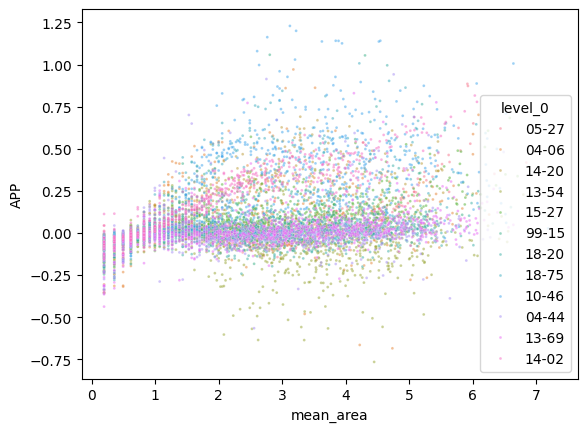

In [164]:
combined_impacts = pd.concat({folder: per_folder_lipid_impact[folder]["Microglia-PVM"] for folder in per_folder_lipid_impact}) \
    .reset_index() \
    .drop("level_1", axis=1)

sns.scatterplot(
    combined_impacts,
    x="mean_area",
    y="APP",
    hue="level_0",
    alpha = .5,
    s=4
)

In [ ]:
def fit_spline(X, y):
    sorted_index = y.sort_values().index
    X = X.loc[sorted_index]
    y = y.loc[sorted_index]
    return UnivariateSpline(y, X)

def compute_spline_covariance(fitted_splines: list, sigma = 0.1):
    spline_matrix = np.stack([spline(np.linspace(y.min(), y.max(), 200)) for spline in fitted_splines])
    pairwise_dists = np.linalg.norm(
        spline_matrix[:, None, :] - spline_matrix[None, :, :], axis=2
    )
    median_dist = np.median(pairwise_dists)
    sigma = median_dist if median_dist > 0 else sigma
    K = rbf_kernel(spline_matrix, gamma=1/(2*sigma**2))

    return K

## Random Thought
Good method to determine the covariance between multiple items, clustering by time.

In [ ]:
import numpy as np
from scipy.interpolate import UnivariateSpline
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

sorted_index = per_folder_lipid_impact["05-27"]["Microglia-PVM"]["mean_area"].sort_values().index

fitted_splines = {}
for gene in adata.var_names:
    X = per_folder_lipid_impact["05-27"]["Microglia-PVM"][gene].loc[sorted_index]
    y = per_folder_lipid_impact["05-27"]["Microglia-PVM"]["mean_area"].loc[sorted_index]
    fitted_splines[gene] = UnivariateSpline(y, X)

spline_matrix = np.stack([spline(np.linspace(y.min(), y.max(), 200)) for spline in fitted_splines.values()])
dists = squareform(pdist(spline_matrix, metric='euclidean'))  # or 'sqeuclidean'

/home/jhaberbe/Projects/Personal/ate/.venv/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/jhaberbe/Projects/Personal/ate/.venv/lib/python3.13/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/home/jhaberbe/Projects/Personal/ate/.venv/lib/python3.13/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/jhaberbe/Projects/Personal/ate/.venv/lib/python3.13/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


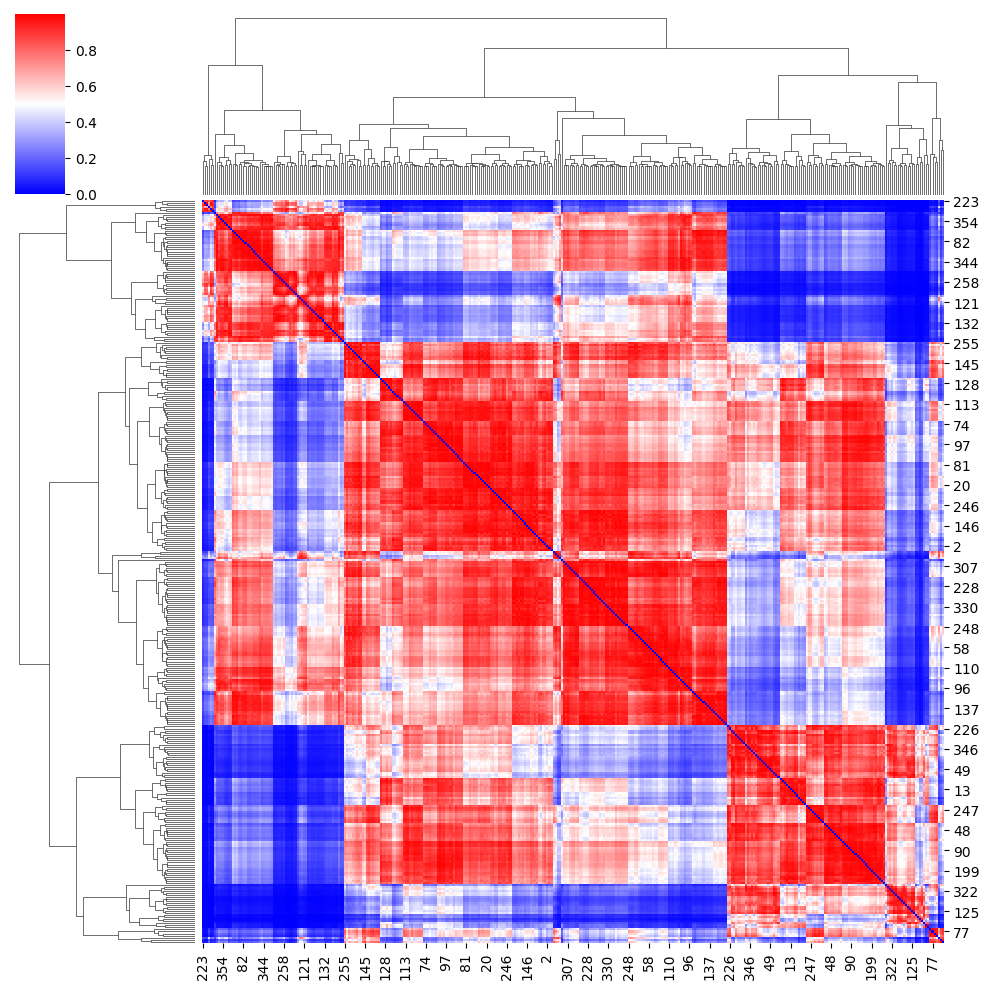

In [136]:
sns.clustermap(
    K - np.eye(K.shape[0]),
    cmap="bwr"
)

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel

def fit_splines():
# spline_matrix: shape (n_vars, n_points)
# Choose a bandwidth sigma (length scale)
sigma = 0.1  # tune this value or use median heuristic below

# median heuristic to pick sigma
pairwise_dists = np.linalg.norm(
    spline_matrix[:, None, :] - spline_matrix[None, :, :], axis=2
)
median_dist = np.median(pairwise_dists)
sigma = median_dist if median_dist > 0 else sigma

# Compute RBF kernel matrix (covariance)
K = rbf_kernel(spline_matrix, gamma=1/(2*sigma**2))

# K[i,j] is the nonlinear covariance/similarity between f_i and f_j


In [140]:
from sklearn.cluster import SpectralClustering

n_clusters = 5  # set as needed
sc = SpectralClustering(n_clusters=n_clusters, random_state=0)
labels = sc.fit_predict(K - np.eye(K.shape[0]))

/home/jhaberbe/Projects/Personal/ate/.venv/lib/python3.13/site-packages/sklearn/cluster/_spectral.py:703: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


In [144]:
import numpy as np
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score

def spectral_clustering_best_k(kernel, k_min=2, k_max=10, verbose=False):
    best_k = None
    best_score = -1
    best_labels = None

    for k in range(k_min, k_max + 1):
        clustering = SpectralClustering(
            n_clusters=k, affinity='precomputed', random_state=0
        )
        labels = clustering.fit_predict(K)

        # Silhouette requires feature matrix or distance matrix.
        # Here use distance matrix derived from similarity
        dist_matrix = 1 - K  # similarity -> distance

        score = silhouette_score(dist_matrix, labels, metric='precomputed')

        if verbose:
            print(f"k={k}, silhouette score={score:.4f}")

        if score > best_score:
            best_score = score
            best_k = k
            best_labels = labels

    return best_k, best_labels, best_score

_, labels, _ = spectral_clustering_best_k(K, k_min=4, verbose=True)

k=4, silhouette score=0.2804
k=5, silhouette score=0.3823
k=6, silhouette score=0.3602
k=7, silhouette score=0.3812
k=8, silhouette score=0.3264
k=9, silhouette score=0.3687
k=10, silhouette score=0.3338
